# SageMaker Built-In Algorithms: Tabular Classification using LightGBM

---
Welcome to Amazon [SageMaker Built-In Algorithms](https://docs.aws.amazon.com/sagemaker/latest/dg/studio-jumpstart.html)! You can use Sagemaker Built-In Algorithms to solve many Machine Learning tasks through one-click in SageMaker Studio, or through [SageMaker Python SDK](https://sagemaker.readthedocs.io/en/stable/overview.html#use-prebuilt-models-with-sagemaker-jumpstart). 

In this demo notebook, we demonstrate how to use the SageMaker Python SDK for tabular data classification using two popular algorithms: [LightGBM](https://lightgbm.readthedocs.io/en/latest/) and [CatBoost](https://catboost.ai/en/docs/). Tabular classification is the task of assigning a class to an example of structured or relational data. The SageMaker Python SDK for tabular classification can be used for classification of an example in two classes (binary classification) or more than two classes (multi-class classification).


In this notebook, we demonstrate two use cases of tabular classification models:

* How to train a tabular model on an example dataset to do multi-class classification.
* How to use the trained tabular model to perform inference, i.e., classifying new samples.

Note: This notebook was tested in Amazon SageMaker Studio on ml.t3.medium instance with Python 3 (Data Science) kernel.

---

1. [Set Up](#1.-Set-Up)
2. [Train A Tabular Model on MNIST Dataset](#2.-Train-a-Tabular-Model-on-MNIST-Dataset)
    * [Retrieve Training Artifacts](#2.1.-Retrieve-Training-Artifacts)
    * [Set Training Parameters](#2.2.-Set-Training-Parameters)
    * [Start Training](#2.3.-Start-Training)
3. [Deploy and Run Inference on the Trained Tabular Model](#3.-Deploy-and-Run-Inference-on-the-Trained-Tabular-Model)
4. [Evaluate the Prediction Results Returned from the Endpoint](#4.-Evaluate-the-Prediction-Results-Returned-from-the-Endpoint)

## 1. Set Up

---
Before executing the notebook, there are some initial steps required for setup. This notebook requires ipywidgets.

---

In [26]:
%%capture
!pip install ipywidgets==7.0.0 --quiet


---
To train and host on Amazon Sagemaker, we need to setup and authenticate the use of AWS services. Here, we use the execution role associated with the current notebook instance as the AWS account role with SageMaker access. It has necessary permissions, including access to your data in S3. 

---

In [27]:
# Import sagemaker_datawrangler which will enable an enhanced visualization and data prep widget for Pandas.
try:
    import sagemaker_datawrangler
except ImportError:
    # sagemaker_datawrangler is available in Data Science Kernel Image
    pass

In [28]:
import sagemaker, boto3, json
from sagemaker.session import Session

sagemaker_session = Session()
aws_role = sagemaker_session.get_caller_identity_arn()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()

## 2. Train a Tabular Model

The following instructions were used for formating the training data as input to the model: 

A S3 path should contain two sub-directories 'train/', 'validation/' (optional), and a json-format file named 'categorical_index.json' (optional). Each sub-directory contains a 'data.csv' file (The MNIST dataset used in this example has been prepared and saved in `training_dataset_s3_path` shown below).
* The 'data.csv' files under sub-directory 'train/' and 'validation/' are for training and validation, respectively. The validation data is used to compute a validation score at the end of each boosting iteration. An early stopping is applied when the validation score stops improving. If the validation data is not provided, a 20% of training data is randomly sampled to serve as the validation data. 

* The first column of the 'data.csv' should have the corresponding target variable. The rest of other columns should have the corresponding predictor variables (features). 

* If the predictors include categorical feature(s), a json-format file named 'categorical_index.json' should be included in the input directory to indicate the column index(es) of the categorical features. Within the json-format file, it should have a python directory where the key is a string of 'cat_index_list' and the value is a list of unique integer(s). Each integer in the list indicates the column index of categorical features in the 'data.csv'. The range of each integer should be more than 0 (index 0 indicates the target) and less than the total number of columns.   

* All the categorical features and the target must be encoded as non-negative integers (```int```) less than ```Int32.MaxValue``` (2147483647). It is best to use a contiguous range of integers started from zero.

* Note. The number of json-format files should be no more than 1 in the input directory.  


Citations:

- [LeCun et al., 1998a] Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. 'Gradient-based learning applied to document recognition.' Proceedings of the IEEE, 86(11):2278-2324, November 1998

In [29]:
import boto3
import sagemaker
import warnings
warnings.filterwarnings("ignore")

session = boto3.session.Session()
region = session.region_name
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()

In [30]:
df_train=pd.read_csv("s3://{}/train/data.csv".format(bucket))
df_train

        1  38.9943  -76.9921  1.0  1.1  0  0.1  0.2  0.3  0.4  ...  0.24  \
0       0  40.8370  -96.7192  1.0    0  0    0    0    0    0  ...     0   
1       1  35.5976  -77.3774  1.0    1  0    0    0    0    0  ...     0   
2       0  40.6872  -89.6096  2.0    1  0    0    0    0    0  ...     0   
3       1  36.5394 -119.2920  1.0    0  0    0    0    0    0  ...     0   
4       1  37.3022  -77.2965  1.0    0  0    0    0    0    0  ...     0   
...    ..      ...       ...  ...  ... ..  ...  ...  ...  ...  ...   ...   
198303  1  40.8680  -73.8959  1.0    1  0    0    0    0    0  ...     0   
198304  1  41.2159  -75.9208  1.0    0  0    1    0    1    1  ...     0   
198305  1  38.5545  -90.4080  1.0    0  0    0    0    1    0  ...     0   
198306  0  39.9323  -75.1179  2.0    1  0    0    0    0    0  ...     0   
198307  1  35.0290  -85.2731  1.0    0  0    0    0    0    0  ...     0   

        0.25  0.26  0.27  0.28  0.29  0.30  1.3  0.31  0.32  
0          0     0     0 

### 2.1. Retrieve Training Artifacts

___

Here, we retrieve the training docker container, the training algorithm source, and the tabular algorithm. Note that model_version="*" fetches the latest model.

For the training algorithm, we have two choices in this demonstration.
* [LightGBM](https://lightgbm.readthedocs.io/en/latest/): To use this algorithm, specify `train_model_id` as `lightgbm-classification-model` in the cell below.
* [CatBoost](https://catboost.ai/en/docs/): To use this algorithm, specify `train_model_id` as `catboost-classification-model` in the cell below.

Note. [XGBoost](https://xgboost.readthedocs.io/en/latest/) (`train_model_id: xgboost-classification-model`) and [Linear Learner](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) (`train_model_id: sklearn-classification-linear`) are the other choices in the tabular classification category. Since they have different input-format requirements, please check a separate notebook `Amazon_JumpStart_Tabular_Classification_XGBoost_LinearLearner.ipynb` for details.


---

***
You can continue with the default model, or can choose a different model from the dropdown generated upon running the next cell. A complete list of SageMaker pre-trained models can also be accessed at [Sagemaker pre-trained Models](https://sagemaker.readthedocs.io/en/stable/doc_utils/pretrainedmodels.html#).
***

In [31]:
model_id, model_version = "lightgbm-classification-model", "*"

***
[Optional] Select a different Sagemaker pre-trained model. Here, we download the model_manifest file from the Built-In Algorithms s3 bucket, filter-out all the Tabular Classification models and select a model for inference.
***

In [32]:
from ipywidgets import Dropdown
from sagemaker.jumpstart.notebook_utils import list_jumpstart_models
from sagemaker.jumpstart.filters import And

# Retrieves all lightgbm and catboost classification models available by SageMaker Built-In Algorithms.
filter_value = And(f"framework in ['lightgbm', 'catboost']", "task == classification")

text_embedding_models = list_jumpstart_models(filter=filter_value)

# display the model-ids in a dropdown to select a model for inference.
model_dropdown = Dropdown(
    options=text_embedding_models,
    value=model_id,
    description="Select a model",
    style={"description_width": "initial"},
    layout={"width": "max-content"},
)

#### Chose a model for training

In [33]:
display(model_dropdown)

A Jupyter Widget

In [34]:
from sagemaker import image_uris, model_uris, script_uris

train_model_id, train_model_version, train_scope = model_dropdown.value, model_version, "training"
training_instance_type = "ml.m5.xlarge"

# Retrieve the docker image
train_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    model_id=train_model_id,
    model_version=train_model_version,
    image_scope=train_scope,
    instance_type=training_instance_type,
)
# Retrieve the training script
train_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope=train_scope
)
# Retrieve the pre-trained model tarball to further fine-tune
train_model_uri = model_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, model_scope=train_scope
)

### 2.2. Set Training Parameters

---

Now that we are done with all the setup that is needed, we are ready to train our tabular algorithm. To begin, let us create a [``sageMaker.estimator.Estimator``](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html) object. This estimator will launch the training job. 

There are two kinds of parameters that need to be set for training. The first one are the parameters for the training job. These include: (i) Training data path. This is S3 folder in which the input data is stored, (ii) Output path: This the s3 folder in which the training output is stored. (iii) Training instance type: This indicates the type of machine on which to run the training.

The second set of parameters are algorithm specific training hyper-parameters. 

---

In [35]:
training_data_bucket ="{}".format(bucket)
training_data_prefix = "train/data.csv"

training_dataset_s3_path = f"s3://{training_data_bucket}/{training_data_prefix}"

output_bucket = sess.default_bucket()
output_prefix = "lightgbm_classification"

s3_output_location = f"s3://{output_bucket}/{output_prefix}/output"

print("The S3 path for the training dataset is: {}".format(training_dataset_s3_path))
print("The S3 output location is: {}".format(s3_output_location))

The S3 path for the training dataset is: s3://sagemaker-us-east-1-458903497716/train/data.csv
The S3 output location is: s3://sagemaker-us-east-1-458903497716/lightgbm_classification/output


---
For algorithm specific hyper-parameters, we start by fetching python dictionary of the training hyper-parameters that the algorithm accepts with their default values. This can then be overridden to custom values.

---

In [36]:
from sagemaker import hyperparameters

# Retrieve the default hyper-parameters for fine-tuning the model
hyperparameters = hyperparameters.retrieve_default(
    model_id=train_model_id, model_version=train_model_version
)

# [Optional] Override default hyperparameters with custom values
hyperparameters[
    "num_boost_round"
] = "500"  # The same hyperparameter is named as "iterations" for CatBoost
print(hyperparameters)

{'num_boost_round': '500', 'early_stopping_rounds': '30', 'metric': 'auto', 'learning_rate': '0.009', 'num_leaves': '67', 'feature_fraction': '0.74', 'bagging_fraction': '0.53', 'bagging_freq': '5', 'max_depth': '11', 'min_data_in_leaf': '26', 'max_delta_step': '0.0', 'lambda_l1': '0.0', 'lambda_l2': '0.0', 'boosting': 'gbdt', 'min_gain_to_split': '0.0', 'scale_pos_weight': '1.0', 'tree_learner': 'serial', 'feature_fraction_bynode': '1.0', 'is_unbalance': 'False', 'max_bin': '255', 'num_threads': '0', 'verbosity': '1', 'use_dask': 'False'}


### 2.3. Start Training

---
We start by creating the estimator object with all the required assets and then launch the training job.

---

In [37]:
from sagemaker.estimator import Estimator
from sagemaker.utils import name_from_base

training_job_name = name_from_base(f"jumpstart-example-{train_model_id}-training")

# Create SageMaker Estimator instance
tabular_estimator = Estimator(
    role=aws_role,
    image_uri=train_image_uri,
    source_dir=train_source_uri,
    model_uri=train_model_uri,
    entry_point="transfer_learning.py",
    instance_count=1,
    instance_type=training_instance_type,
    max_run=360000,
    hyperparameters=hyperparameters,
    output_path=s3_output_location,
)

# Launch a SageMaker Training job by passing s3 path of the training data
tabular_estimator.fit({"training": training_dataset_s3_path}, logs=True, job_name=training_job_name)

2023-04-16 23:26:14 Starting - Starting the training job...
2023-04-16 23:26:29 Starting - Preparing the instances for training...
2023-04-16 23:27:11 Downloading - Downloading input data...
2023-04-16 23:27:31 Training - Downloading the training image...
2023-04-16 23:28:01 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-04-16 23:28:07,836 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-04-16 23:28:07,838 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-04-16 23:28:07,847 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-04-16 23:28:07,849 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-04-16 23:28:08,119 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/o

## 3. Deploy and Run Inference on the Trained Tabular Model

---

In this section, you learn how to query an existing endpoint and make predictions of the examples you input. For each example, the model will output the probability of the sample for each class in the model. 
Next, the predicted class label is obtained by taking the class label with the maximum probability over others. 


We start by retrieving the artifacts and deploing the `tabular_estimator` that we trained.

---

In [38]:
inference_instance_type = "ml.m5.large"

# Retrieve the inference docker container uri
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    image_scope="inference",
    model_id=train_model_id,
    model_version=train_model_version,
    instance_type=inference_instance_type,
)
# Retrieve the inference script uri
deploy_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope="inference"
)

endpoint_name = name_from_base(f"jumpstart-example-{train_model_id}-")

# Use the estimator from the previous step to deploy to a SageMaker endpoint
predictor = tabular_estimator.deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    entry_point="inference.py",
    image_uri=deploy_image_uri,
    source_dir=deploy_source_uri,
    endpoint_name=endpoint_name,
)

--

/opt/conda/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


---!

---
Next, we download the test data from the S3 bucket for inference.

---

In [40]:
jumpstart_assets_bucket = "{}".format(bucket)
test_data_prefix = "test"
test_data_file_name = "data.csv"

boto3.client("s3").download_file(
    jumpstart_assets_bucket, f"{test_data_prefix}/{test_data_file_name}", test_data_file_name
)

---
Next, we read the MNIST test data into pandas data frame, prepare the ground truth target and predicting features to send into the endpoint. 

Below is the screenshot of the first 5 examples in the MNIST test set. All of the test examples with features 
from ```Feature_1``` to ```Feature_784``` are sent into the deployed model to get model predictions, 
to estimate the ground truth ```Target``` column. For each test example, the model will output 
a vector of ```num_classes``` elements, where each element is the probability of the example for each class in the model. 
The ```num_classes``` is 10 in this case. Next, the predicted class label is obtained by taking the class label 
with the maximum probability over others. 

---

In [41]:
newline, bold, unbold = "\n", "\033[1m", "\033[0m"

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# read the data
test_data = pd.read_csv(test_data_file_name, header=None)
test_data.columns = ["Target"] + [f"Feature_{i}" for i in range(1, test_data.shape[1])]

num_examples, num_columns = test_data.shape
print(
    f"{bold}The test dataset contains {num_examples} examples and {num_columns} columns.{unbold}\n"
)

# prepare the ground truth target and predicting features to send into the endpoint.
ground_truth_label, features = test_data.iloc[:, :1], test_data.iloc[:, 1:]

print(f"{bold}The first 5 observations of the data: {unbold} \n")
test_data.head(5)

The test dataset contains 11018 examples and 40 columns.

The first 5 observations of the data:  



   Target  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  Feature_6  \
0       0    39.9230   -91.3838        1.0          0          0          1   
1       1    41.5156   -81.5664        1.0          1          0          0   
2       0    43.4906  -112.0310        1.0          0          0          0   
3       1    34.8786   -92.0932        1.0          0          0          0   
4       0    27.7329   -98.0732        1.0          1          0          0   

   Feature_7  Feature_8  Feature_9  ...  Feature_30  Feature_31  Feature_32  \
0          0          0          0  ...           0           0           0   
1          0          0          0  ...           0           0           0   
2          0          0          0  ...           0           0           0   
3          0          1          1  ...           1           0           0   
4          0          0          0  ...           0           0           0   

   Feature_33  Feature_34  Feature_35  Feature_36 

---
The following code queries the endpoint you have created to get the prediction for each test example. 
The `query_endpoint()` function returns a array-like of shape (num_examples, num_classes), where each row indicates 
the probability of the example for each class in the model. The num_classes is 10 in above test data. 
Next, the predicted class label is obtained by taking the class label with the maximum probability over others for each example. 

---

In [42]:
content_type = "text/csv"


def query_endpoint(encoded_tabular_data):
    # endpoint_name = endpoint_name
    client = boto3.client("runtime.sagemaker")
    response = client.invoke_endpoint(
        EndpointName=endpoint_name, ContentType=content_type, Body=encoded_tabular_data
    )
    return response


def parse_response(query_response):
    model_predictions = json.loads(query_response["Body"].read())
    predicted_probabilities = model_predictions["probabilities"]
    return np.array(predicted_probabilities)


# split the test data into smaller size of batches to query the endpoint due to the large size of test data.
batch_size = 1500
predict_prob = []
for i in np.arange(0, num_examples, step=batch_size):
    query_response_batch = query_endpoint(
        features.iloc[i : (i + batch_size), :].to_csv(header=False, index=False).encode("utf-8")
    )
    predict_prob_batch = parse_response(query_response_batch)  # prediction probability per batch
    predict_prob.append(predict_prob_batch)


predict_prob = np.concatenate(predict_prob, axis=0)
predict_label = np.argmax(
    predict_prob, axis=1
)  # Note. For binary classification, the model returns a array-like of shape (num_examples, 1),
# where each row is the probability of the positive label 1, assuming there are positive label (encoded as 1) and negative label (encoded as 0) in the target.
# To get the probability for both label 0 and 1, execute following code:
# predict_prob = np.vstack((1.0 - predict_prob, predict_prob)).transpose()

## 4. Evaluate the Prediction Results Returned from the Endpoint

---
We evaluate the predictions results returned from the endpoint by following two ways.

* Visualize the predictions results by plotting the confusion matrix.

* Measure the prediction results quantitatively.

---

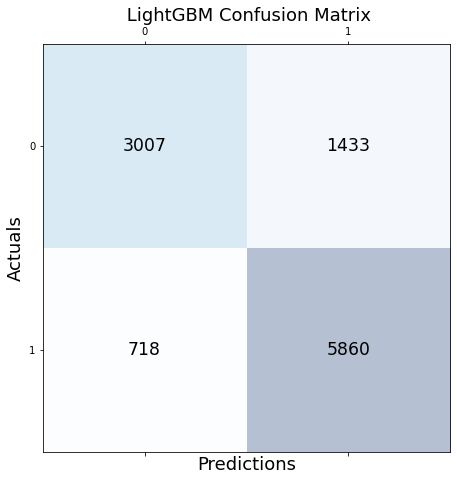

In [46]:
# Visualize the predictions results by plotting the confusion matrix.
conf_matrix = confusion_matrix(y_true=ground_truth_label.values, y_pred=predict_label)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i, s=conf_matrix[i, j], va="center", ha="center", size="xx-large")

plt.xlabel("Predictions", fontsize=18)
plt.ylabel("Actuals", fontsize=18)
plt.title(" LightGBM Confusion Matrix", fontsize=18)
plt.show()

In [47]:
# Measure the prediction results quantitatively.
eval_accuracy = accuracy_score(ground_truth_label.values, predict_label)
eval_f1_macro = f1_score(ground_truth_label.values, predict_label, average="macro")
eval_f1_micro = f1_score(ground_truth_label.values, predict_label, average="micro")

print(
    f"{bold}Evaluation result on test data{unbold}:{newline}"
    f"{bold}{accuracy_score.__name__}{unbold}: {eval_accuracy}{newline}"
    f"{bold}F1 Macro{unbold}: {eval_f1_macro}{newline}"
    f"{bold}F1 Micro{unbold}: {eval_f1_micro}{newline}"
)

Evaluation result on test data:
accuracy_score: 0.804774006171719
F1 Macro: 0.7907433744656995
F1 Micro: 0.804774006171719



/opt/conda/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


---
Next, we delete the endpoint corresponding to the finetuned model.

---

In [45]:
# Delete the SageMaker endpoint and the attached resources
predictor.delete_model()
predictor.delete_endpoint()